# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = True

In [2]:
# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Local imports
from estimator import Estimator
from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

## Load the data

In [4]:
input_dir = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29'

In [5]:
all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))

n_files = 10
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [6]:
n_workers = 5
with mp.Pool(processes=n_workers) as pool:
    hits = process_hits_files(hits_files, pool)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_13.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_14.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_15.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_16.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_17.csv


## Prepare the dataset

Let's start with a simple subset of the data: perfect tracks in one volume.

I can now prepare a single event and its graph, so how should I move to generating a set of events?
- It might be enough for CTD to stick with artificially constructed events from ideal tracks
- I've learned that for development it should be good enough to write code that prepares a single sample,
  because I can always move that code into a data-prep script and parallelize the call across files, etc.

Ok, then, if I choose fixed number of perfect tracks from each event, I can pre-allocate the storage I need and just loop over samples and fill that storage.

### Selecting good track hits

In [7]:
# For now concatenating everything right away
hits = pd.concat(hits, ignore_index=True)

In [8]:
def select_hits(hits):
    # Select hits from barrel volume 13
    hits = hits[hits.volid==13]
    # Select tracks that hit all layers
    hits = (hits.groupby(['evtid', 'barcode'])
            .filter(lambda x: len(x.layid.unique()) == 4))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['evtid', 'barcode', 'layid'], as_index=False).r.idxmin()
    ]
    return hits

In [9]:
%%time
sel_hits = select_hits(hits)

CPU times: user 3min 10s, sys: 2.1 s, total: 3min 12s
Wall time: 3min 12s


In [10]:
# Select the particle keys
particle_keys = sel_hits[['evtid', 'barcode']].drop_duplicates().values
np.random.shuffle(particle_keys)
particle_keys.shape

(188809, 2)

### Construct the dataset

In [11]:
# Data config
n_tracks = 4
n_samples = particle_keys.shape[0] // n_tracks #1024
feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)
feature_scale = np.array([1000., np.pi, 1000.])
print('Preparing', n_samples, 'samples with', n_tracks, 'tracks each')
assert n_samples <= (particle_keys.shape[0] // n_tracks), 'Not enough tracks!'

Preparing 47202 samples with 4 tracks each


In [12]:
# Fixed number of hits and edges per sample in this dataset
n_det_layers = sel_hits[['volid', 'layid']].drop_duplicates().shape[0]
n_hits = n_tracks * n_det_layers
n_edges = n_tracks**2 * (n_det_layers - 1)
edge_idx = np.arange(n_edges)
n_hits, n_edges

(16, 48)

In [ ]:
# Pre-allocate the dataset storage
full_X = np.zeros((n_samples, n_hits, n_features))
full_Ri = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint16)
full_Ro = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint16)
full_y = np.zeros((n_samples, n_edges), dtype=np.uint16)

In [ ]:
%%time

sig_groups = sel_hits.groupby(['evtid', 'barcode'])

# Loop over samples
for i in range(n_samples):
    # Pick out the particles for this sample
    sample_keys = particle_keys[i*n_tracks:(i+1)*n_tracks]
    sample_hits = pd.concat([sig_groups.get_group(tuple(k)) for k in sample_keys])

    # Select adjacent-layer hit pairs.
    # For now assuming we're all in one volume with standard layid.
    sample_layids = sample_hits.layid.values
    adj_idx = np.stack(np.where((sample_layids[None,:] - sample_layids[:,None]) == 2), axis=1)
    
    # Fill the adjacency matrices
    full_Ri[i, adj_idx[:,1], edge_idx] = 1
    full_Ro[i, adj_idx[:,0], edge_idx] = 1
    
    # Fill the node features
    full_X[i] = sample_hits[feature_names].values / feature_scale
    
    # Fill the edge labels
    barcodes = sample_hits.barcode.values
    bc_in = np.matmul(barcodes[None], full_Ri[i]).squeeze(0)
    bc_out = np.matmul(barcodes[None], full_Ro[i]).squeeze(0)
    full_y[i] = (bc_in == bc_out)

### Visualize one sample

Need to put this code into a function, and write it so it will be easy to use
at model evaluation time (e.g., using model representation of the data).

In [46]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    """
    TODO: make segment coloring configurable.
    """
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0])
    ax1.scatter(X[:,1], X[:,0])
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    ax1.set_xlim(-np.pi, np.pi)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

<IPython.core.display.Javascript object>


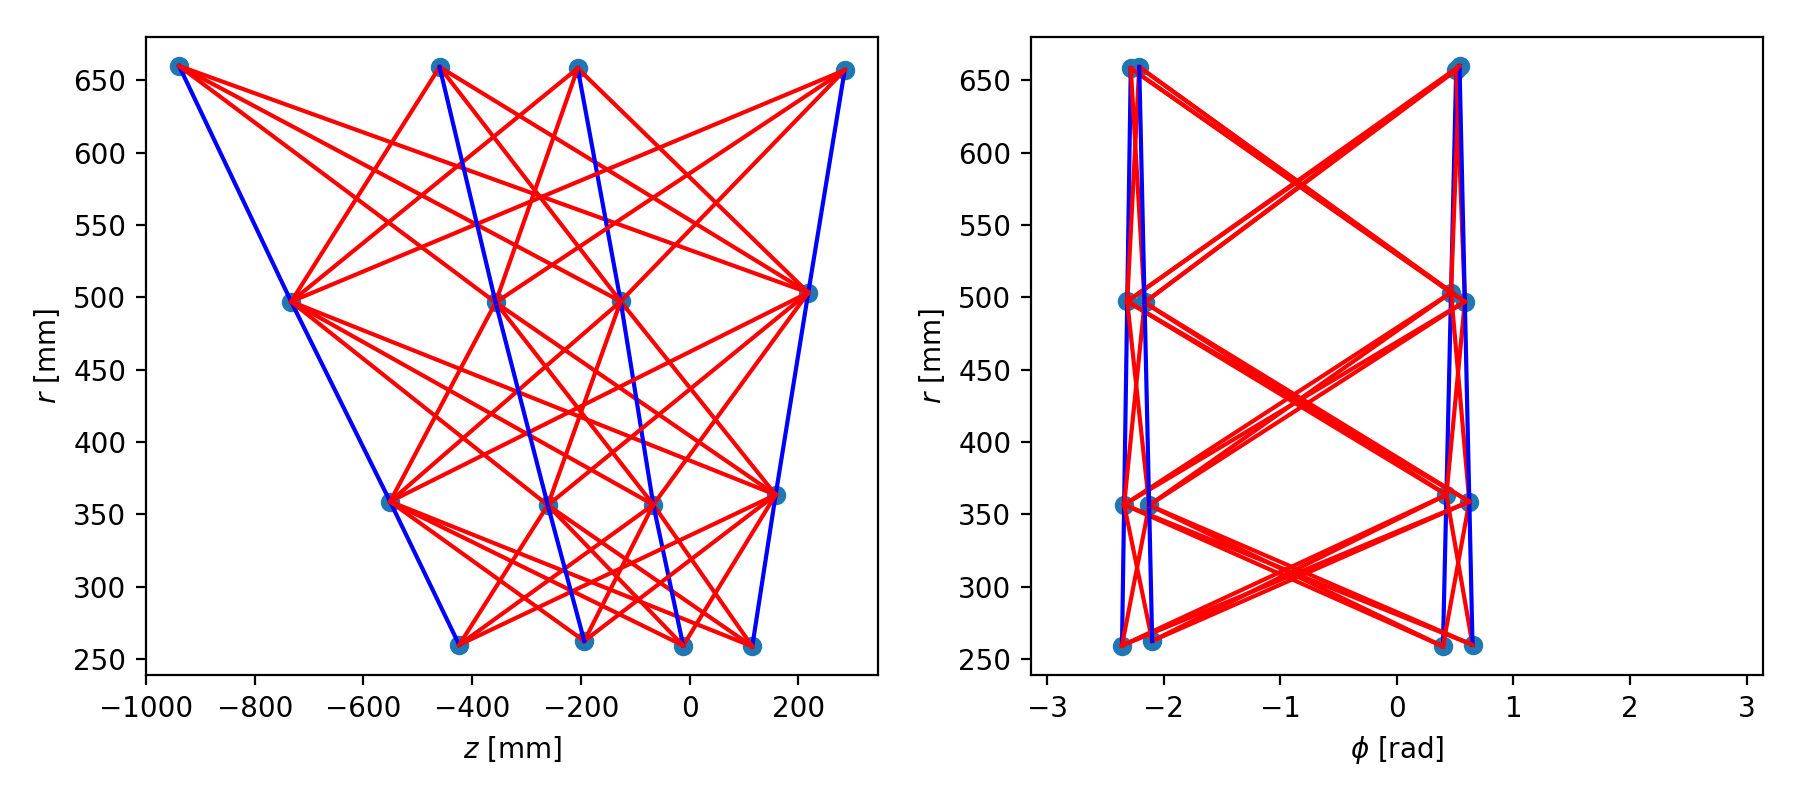

In [47]:
# Choose a sample to draw
i = 0
X = full_X[i] * feature_scale
Ri, Ro = full_Ri[i], full_Ro[i]
y = full_y[i]

draw_sample(X, Ri, Ro, y)

## Define the model

In [ ]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

class SegmentClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)

## Train the model

In [ ]:
# Develop a batch generator here
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            batch_X = np_to_torch(X[j:j+batch_size], volatile=volatile)
            batch_Ri = np_to_torch(Ri[j:j+batch_size], volatile=volatile)
            batch_Ro = np_to_torch(Ro[j:j+batch_size], volatile=volatile)
            batch_y = np_to_torch(y[j:j+batch_size], volatile=volatile)
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

In [34]:
# Model config
hidden_dim = 8
n_iters = 3

# Training config
batch_size = 32
n_epochs = 32
valid_frac = 0.2
test_frac = 0.2

In [35]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(28320, 9440, 9440, 47200)

In [36]:
# Partition the dataset
(train_X, test_X, train_Ri, test_Ri, train_Ro, test_Ro, train_y, test_y) = (
    train_test_split(full_X, full_Ri, full_Ro, full_y, test_size=n_test))
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = (
    train_test_split(train_X, train_Ri, train_Ro, train_y, test_size=n_valid))

print('Train shapes:', train_X.shape, train_Ri.shape, train_Ro.shape, train_y.shape)
print('Valid shapes:', valid_X.shape, valid_Ri.shape, valid_Ro.shape, valid_y.shape)
print('Test shapes: ', test_X.shape, test_Ri.shape, test_Ro.shape, test_y.shape)

Train shapes: (28322, 16, 3) (28322, 16, 48) (28322, 16, 48) (28322, 48)
Valid shapes: (9440, 16, 3) (9440, 16, 48) (9440, 16, 48) (9440, 48)
Test shapes:  (9440, 16, 3) (9440, 16, 48) (9440, 16, 48) (9440, 48)


In [37]:
# Prepare the batch generators
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y,
                                n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y,
                                n_samples=n_valid, batch_size=n_valid)
test_batcher = batch_generator(test_X, test_Ri, test_Ro, test_y,
                               n_samples=n_test, batch_size=n_test)

In [38]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2018-03-14 18:30:49.602238 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=8)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=22, out_features=8)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=1)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=33, out_features=8)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=8)
      (3): Tanh()
    )
  )
)
2018-03-14 18:30:49.602667 Parameters: 569


In [39]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=1)

2018-03-14 18:30:53.124959 Epoch 0
2018-03-14 18:31:00.388469   training loss 0.485 time 7.26336s
2018-03-14 18:31:00.445901   validate loss 0.399
2018-03-14 18:31:00.446012 Epoch 1
2018-03-14 18:31:07.615948   training loss 0.373 time 7.16975s
2018-03-14 18:31:07.673643   validate loss 0.321
2018-03-14 18:31:07.673755 Epoch 2
2018-03-14 18:31:14.793974   training loss 0.231 time 7.12015s
2018-03-14 18:31:14.850906   validate loss 0.164
2018-03-14 18:31:14.851023 Epoch 3
2018-03-14 18:31:21.905705   training loss 0.129 time 7.05449s
2018-03-14 18:31:21.962262   validate loss 0.107
2018-03-14 18:31:21.962373 Epoch 4
2018-03-14 18:31:29.013906   training loss 0.0918 time 7.05146s
2018-03-14 18:31:29.071037   validate loss 0.0817
2018-03-14 18:31:29.071146 Epoch 5
2018-03-14 18:31:36.273540   training loss 0.0737 time 7.2022s
2018-03-14 18:31:36.330231   validate loss 0.0685
2018-03-14 18:31:36.330336 Epoch 6
2018-03-14 18:31:43.482694   training loss 0.0621 time 7.15217s
2018-03-14 18:31

### Loss curves

<IPython.core.display.Javascript object>


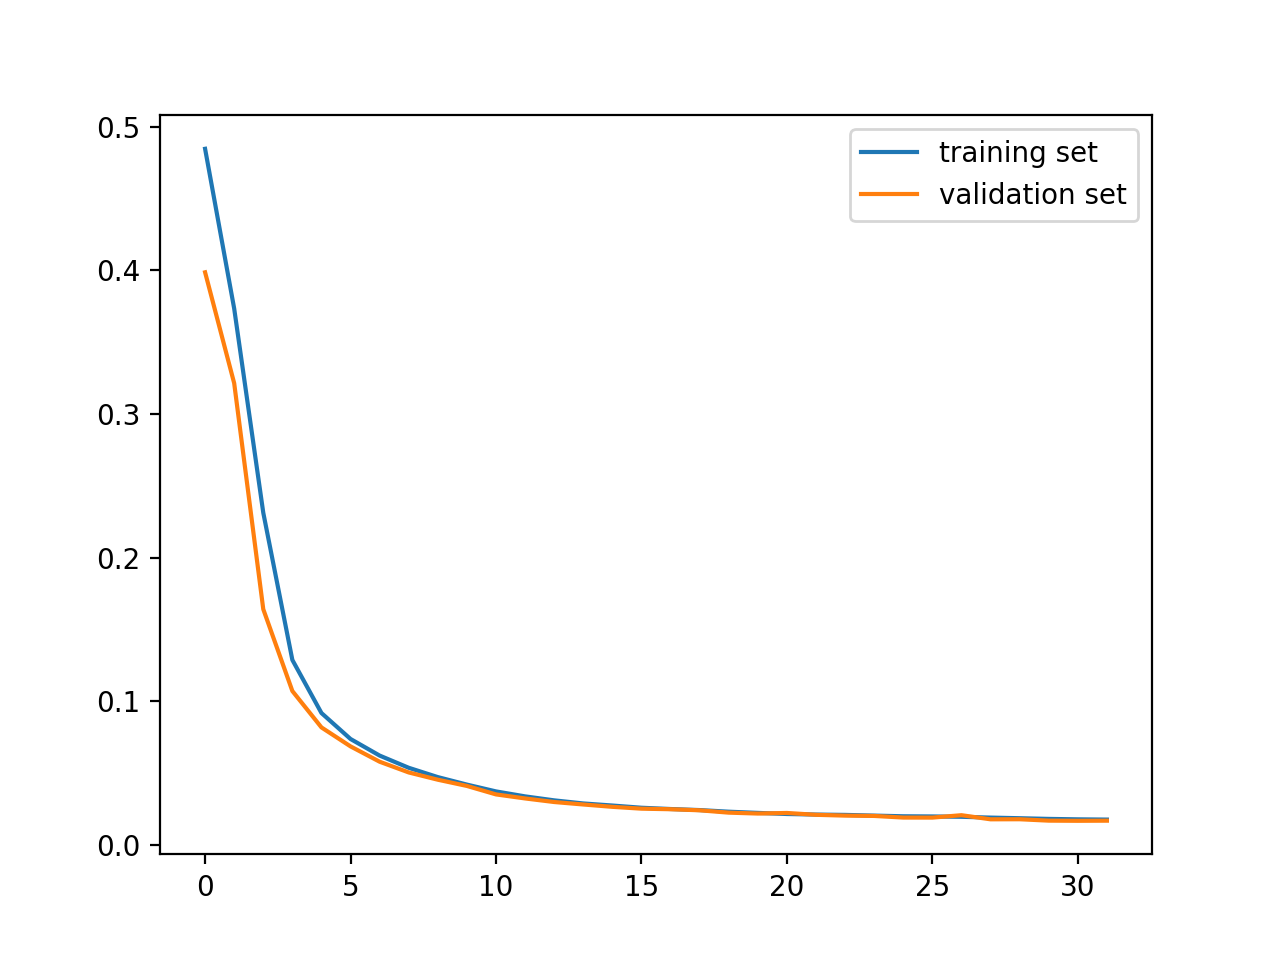

In [41]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.legend(loc=0);

## Evaluate model on the test set

In [42]:
test_input, test_target = next(test_batcher)
estim.model.eval()
test_pred = torch_to_np(estim.model(test_input))

In [43]:
# Compute test set accuracy
matches = (test_pred > 0.5) == (test_y > 0.5)
print('Test set accuracy:', matches.mean())

Test set accuracy: 0.996462305791


<IPython.core.display.Javascript object>


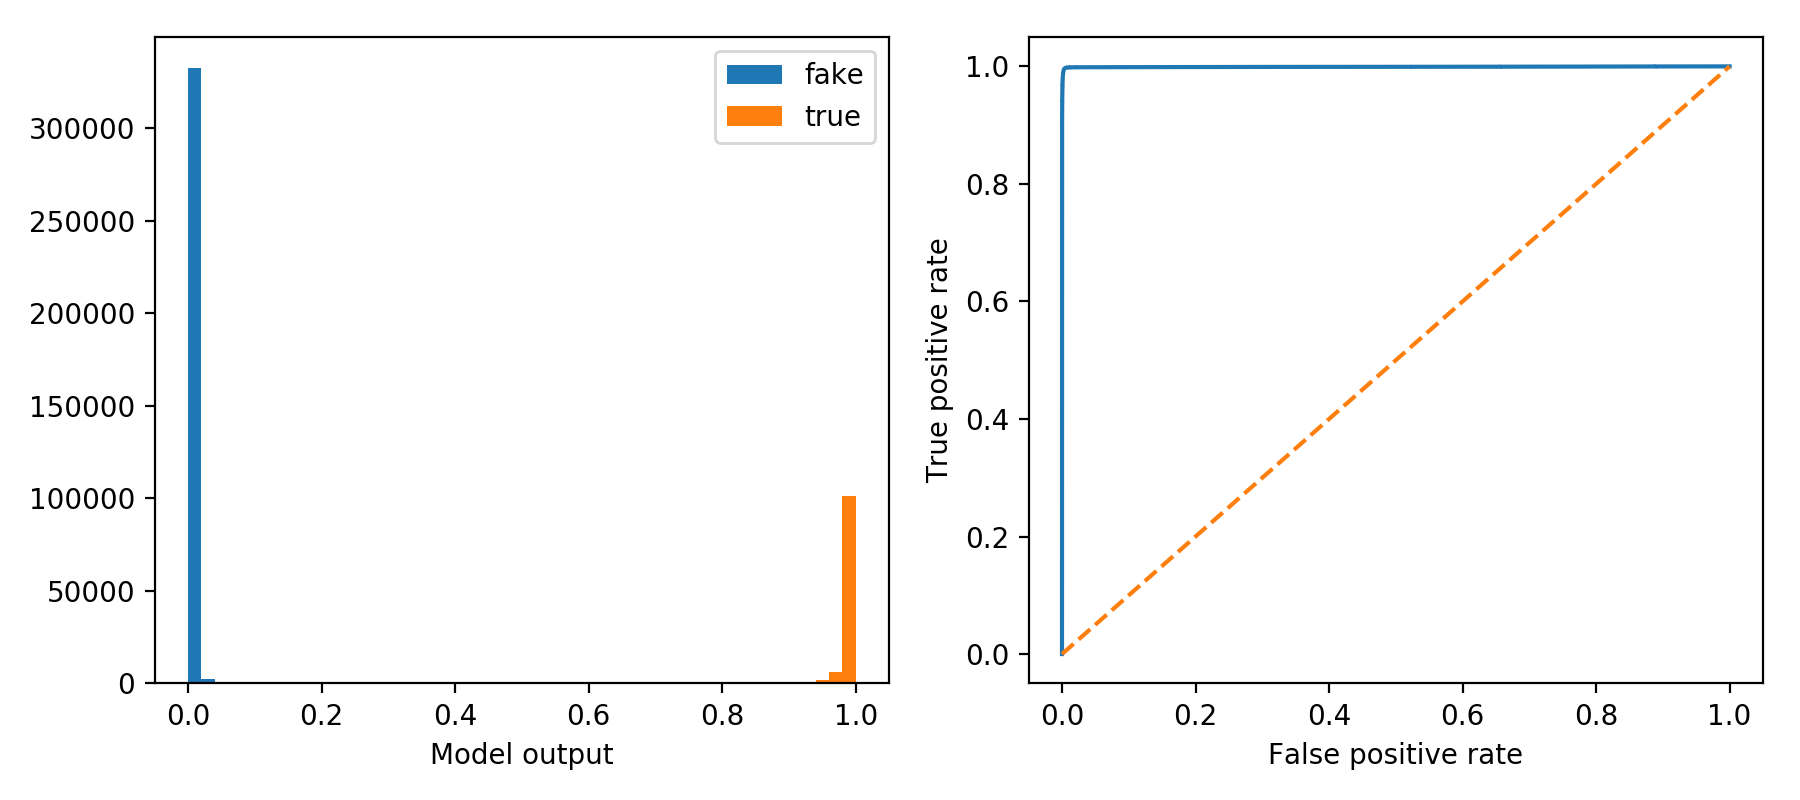

In [44]:
# Compute the ROC curve
flat_y = test_y.flatten()
flat_pred = test_pred.flatten()
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.tight_layout()

## Visualize some samples

<IPython.core.display.Javascript object>


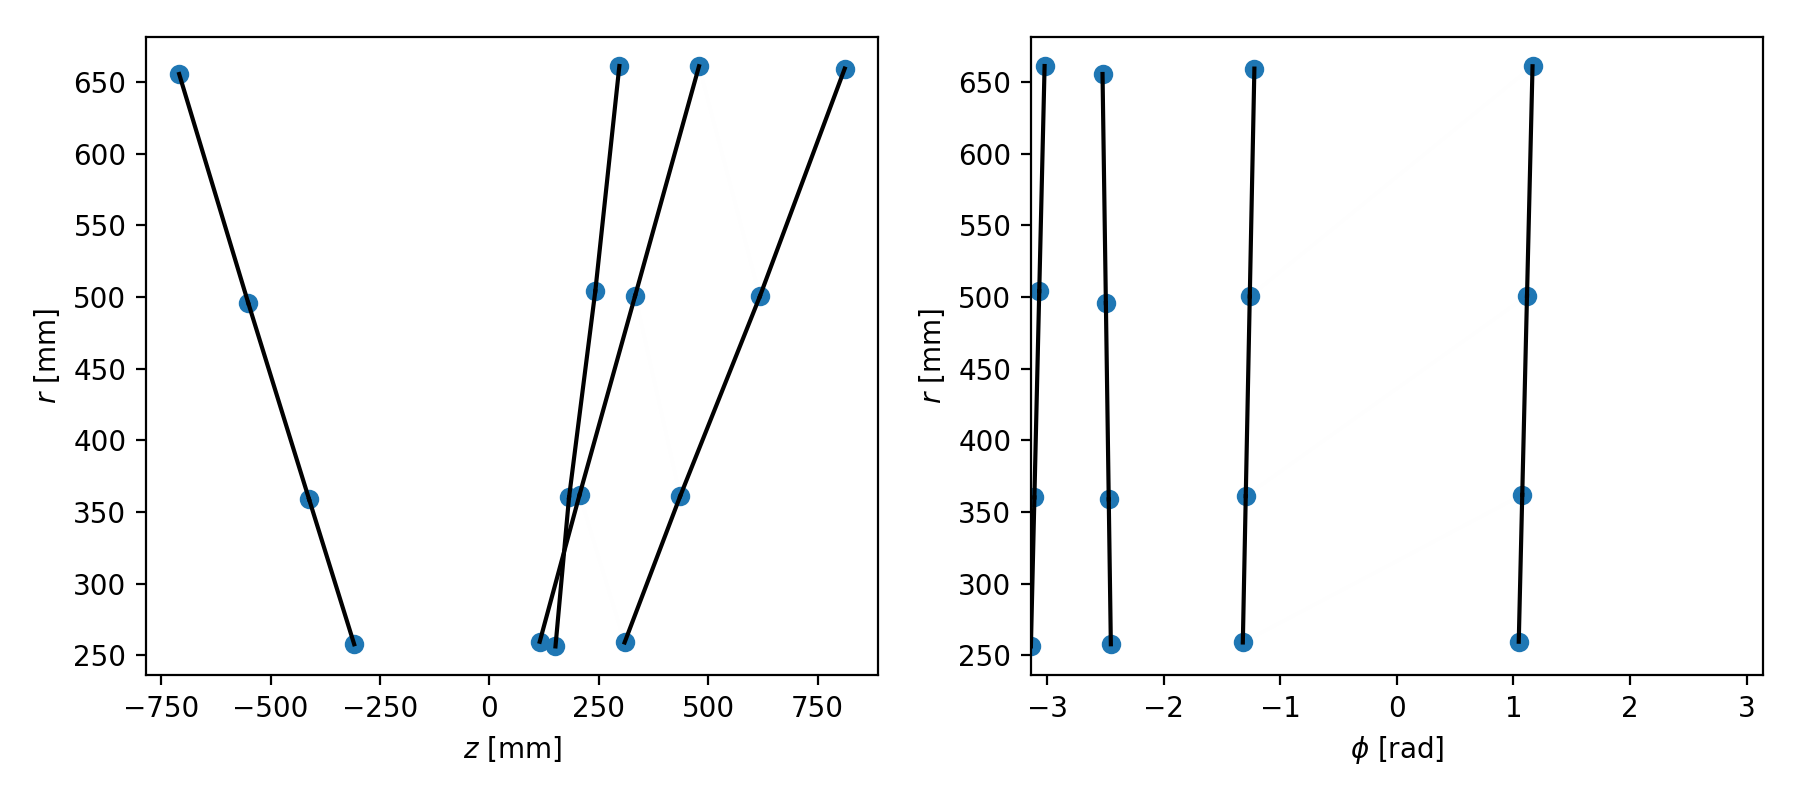

<IPython.core.display.Javascript object>


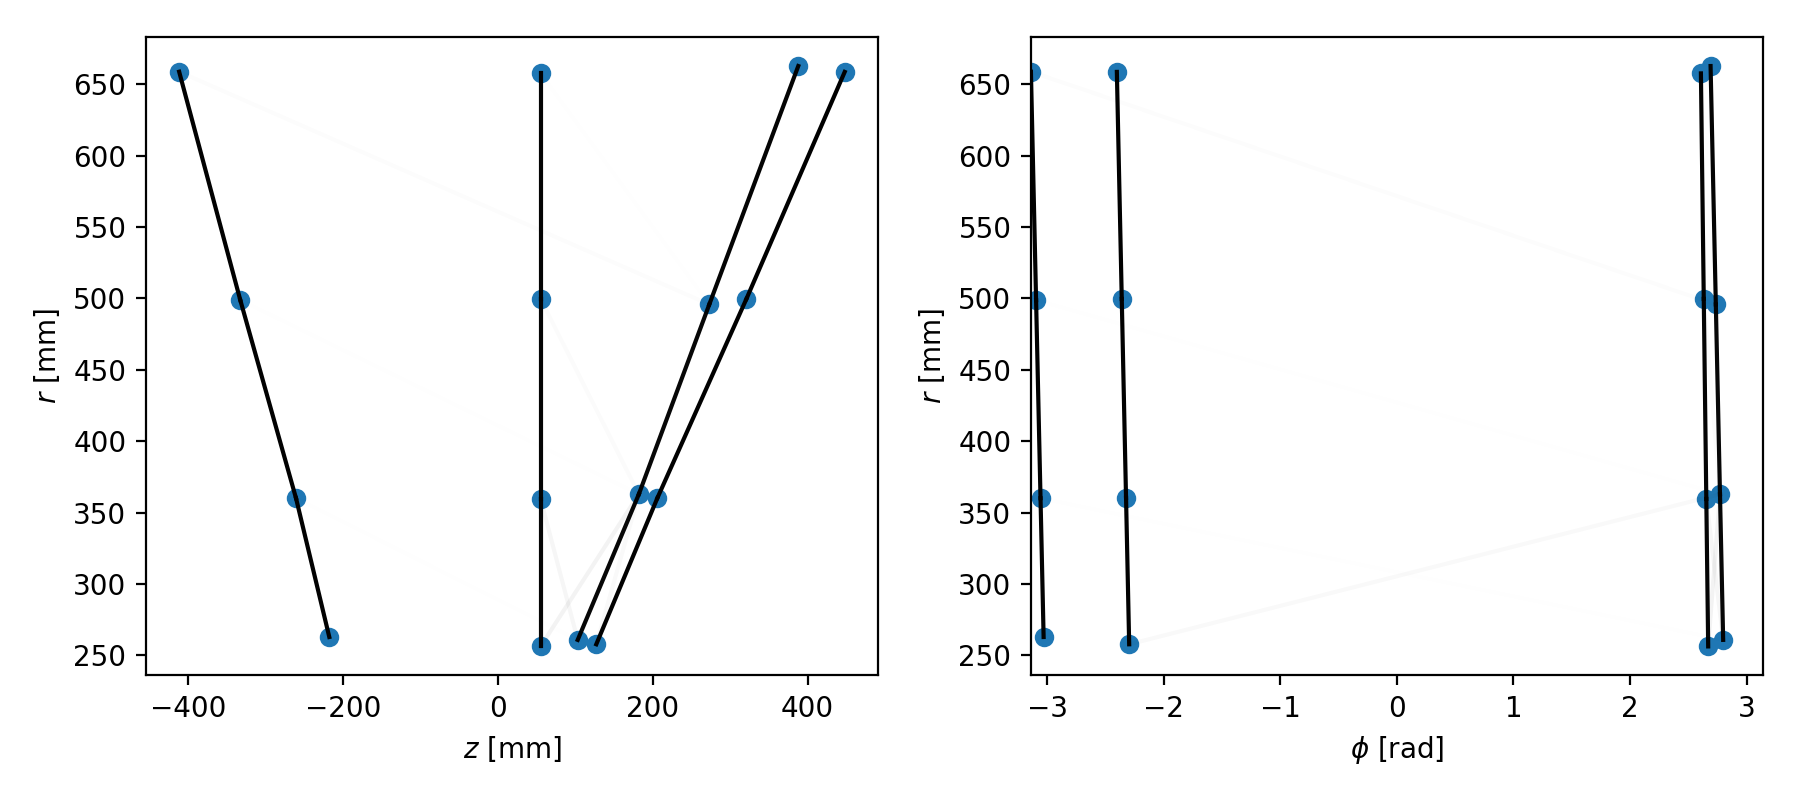

<IPython.core.display.Javascript object>


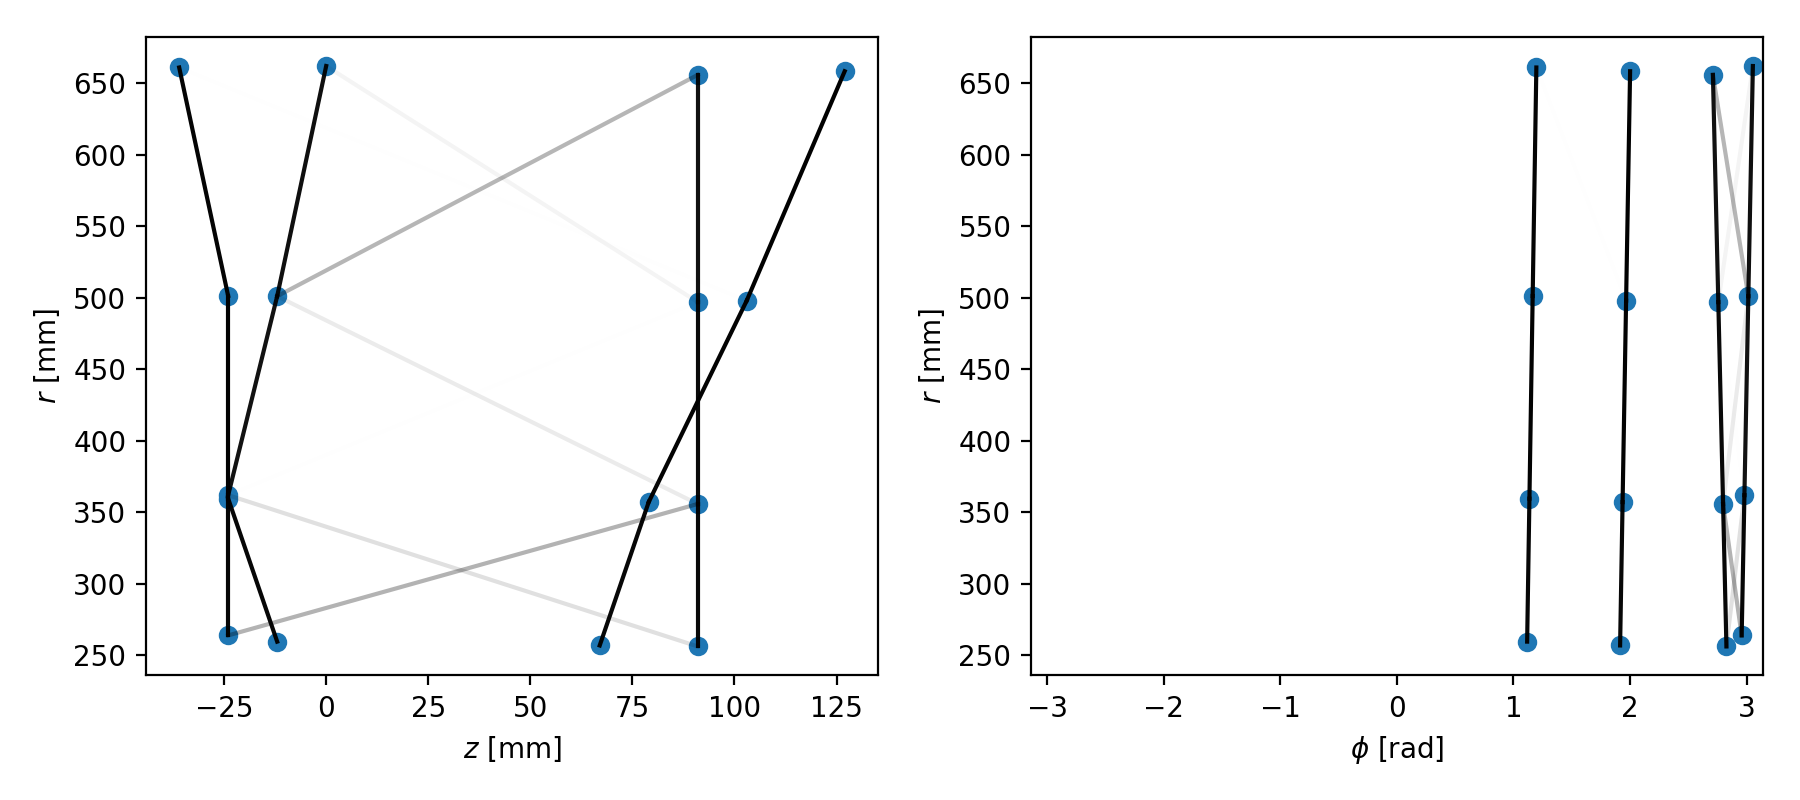

<IPython.core.display.Javascript object>


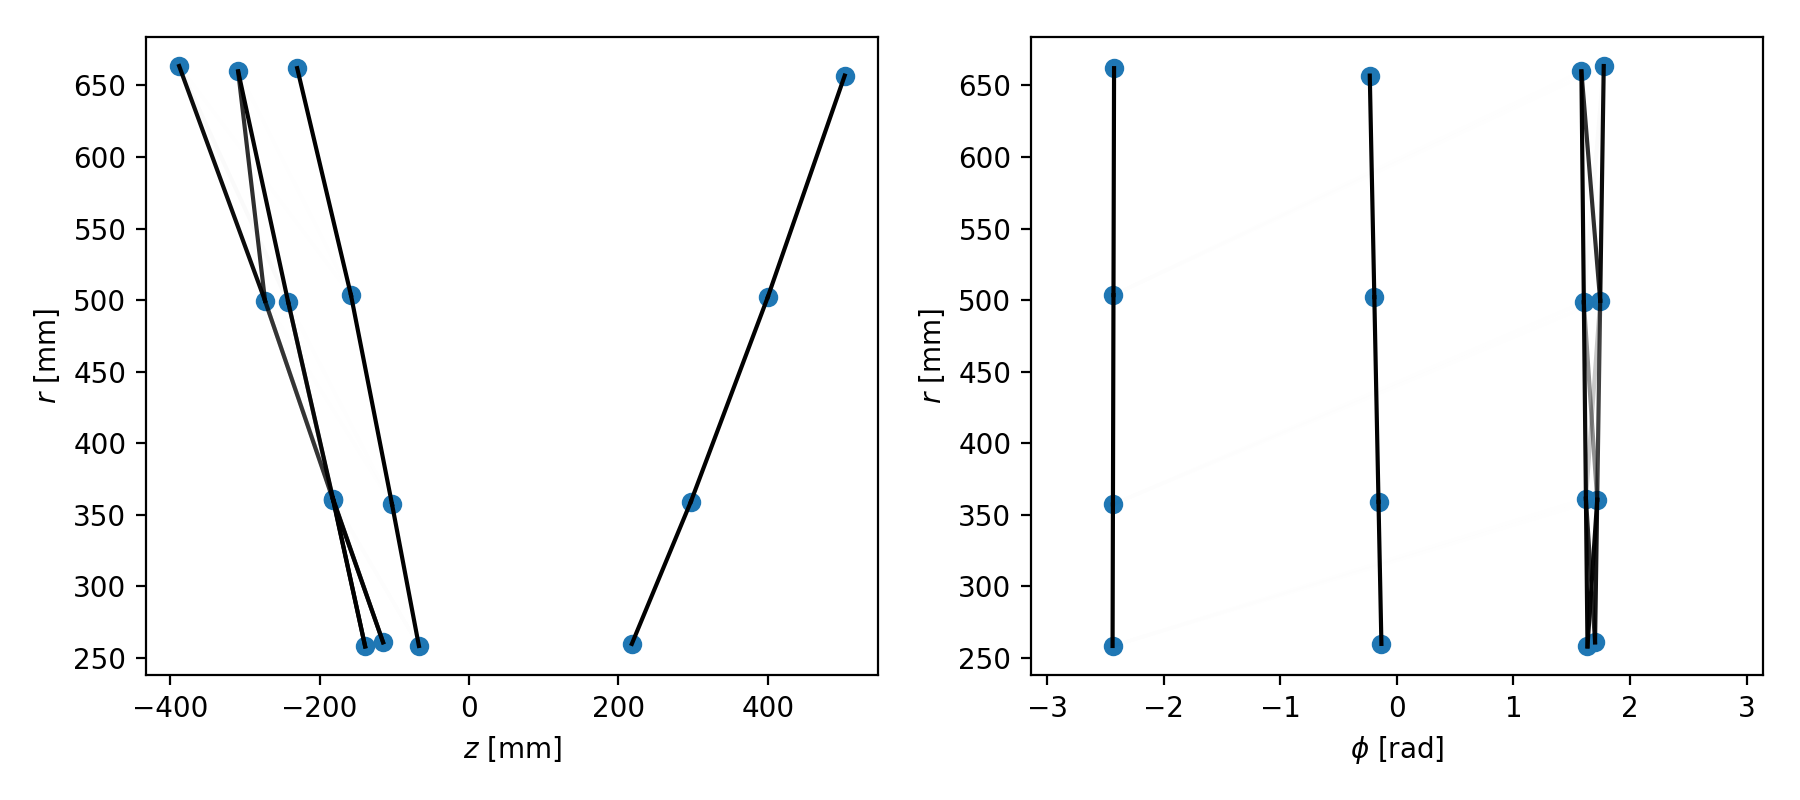

In [48]:
# Start with just one
for i in range(4):
    draw_sample(test_X[i]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i], alpha_labels=True);

## Discussion

It's working so far. Now I need to scale up in terms of number of tracks and layers.